# Topic Modelling using BERTopic & cuBERTopic

Sample notebook to show cuBERTopic, a topic modelling technique that is built on top of the NVIDIA RAPIDS ecoysystem, utilizing libraries such as `cudf` and `cuml` to GPU-accelarate end-to-end workflow for extracting topic from a set of documents. We run the same operations using `BERTopic` to compare their behaviour. 

## Quick Start
In both the cases, we start by extracting topics from the well-known 20 newsgroups dataset from `sklearn` which is comprised of english documents

### Installing relevant packages
Here we need to install relevant dependencies for `BERTopic` as well as we compare performance between it and `cuBERTopic`. 

More detailed instructions are in the README.

In [1]:
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups
from transformers import AutoTokenizer, AutoModel
import torch
from cuBERTopic import gpu_BERTopic
import rmm
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"
rmm.reinitialize(pool_allocator=True,initial_pool_size=5e+9)

### Dataset
```
The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups
```

In [2]:
docs = fetch_20newsgroups(subset='all')['data']

In [3]:
print(docs[30])
print(len(docs))

From: johnson@spectra.com (boyd johnson)
Subject: Re: Automotive crash test, performance and maintenance stats?
Organization: Spectragraphics Corporation
Distribution: usa
Lines: 23

<<I wrote>
<Is there a resource available to the consumer comparing all of the makes
<and models of automobiles, trucks, vans, etc. for survivability in a
<crash of different severities?
<...
<Also, I've found very little objective data comparing different
<vehicles for handling, pick-up, braking, expected maintenance, etc.
<I recall years ago Consumer Reports annual buyer's guide was much more
<informative in those aspects than it is now.

Thanks to a reply from someone I looked a little further and found what
I was looking for.  The April CR magazine has most of the above things.
Despite recent articles here the ratings looked pretty good for
relative comparison purposes.  Unfortunately the crash test comparisons
didn't include half of the cars I'm comparing.
Anybody know how '93 Honda Civic hatchbacks a

### Running `BERTopic`

In [4]:
%%time
topic_model = BERTopic()
topics_cpu, probs_cpu = topic_model.fit_transform(docs)

CPU times: user 16min 28s, sys: 29.6 s, total: 16min 57s
Wall time: 1min 3s


`get_topic_info` returns information about each topic including its id, frequency, and name 

In [5]:
%%time
topic_model.get_topic_info()

CPU times: user 6.43 ms, sys: 79 µs, total: 6.51 ms
Wall time: 5.68 ms


,Topic,Count,Name
0,-1,6015,-1_the_to_and_of
1,0,452,0_gun_guns_firearms_weapons
2,1,439,1_car_cars_ford_engine
3,2,257,2_address_email_list_mailing
4,3,213,3_image_3d_graphics_processing
...,...,...,...
346,345,10,345_jb_placebo_rr_placebos
347,346,10,346_jesus_matthew_josephus_cock
348,347,10,347_socialist_frog_domino_clinton
349,348,10,348_mlbc_yesterday_george_dodgers


`get_topic` returns topics with top n words and their c-TF-IDF score

-1 refers to all outliers and should typically be ignored. Next, let's take a look at the most frequent topic that was generated, topic 0:

In [6]:
%%time
topic_model.get_topic(0)

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 20 µs


[('gun', 0.015550206217170822),
 ('guns', 0.0091615865279445),
 ('firearms', 0.006988966009214122),
 ('weapons', 0.005993514681766531),
 ('militia', 0.00590753722828423),
 ('amendment', 0.005430383361581196),
 ('control', 0.004816241769861381),
 ('crime', 0.004697150337325077),
 ('weapon', 0.004331513026897591),
 ('arms', 0.00426723993174192)]

CPU times: user 93.4 ms, sys: 3.9 ms, total: 97.3 ms
Wall time: 95.6 ms


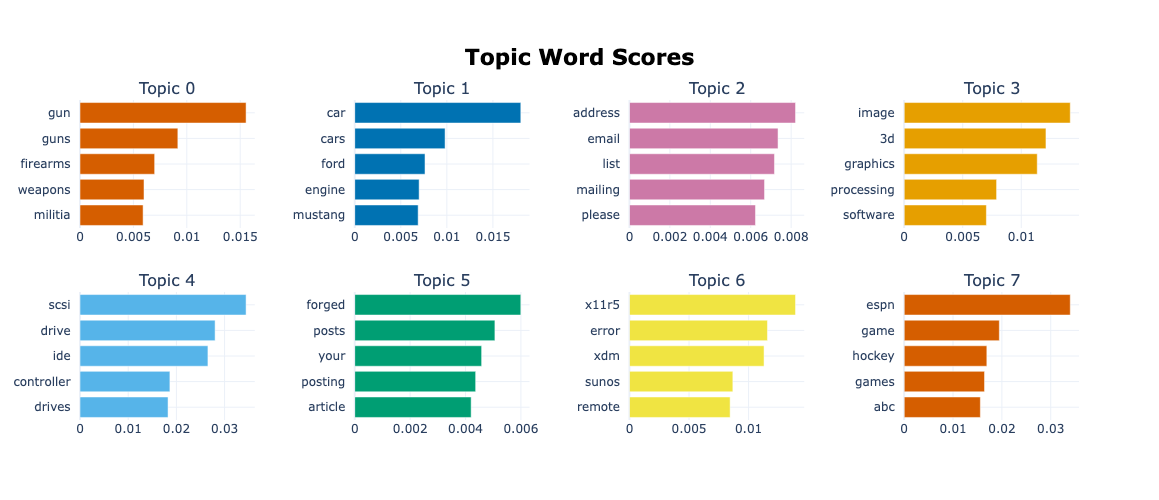

In [20]:
%%time
topic_model.visualize_barchart()

### Running `cuBERTopic`
`cuBERTopic` provides with a similar API for passing in `docs` as a set of strings to model on. Here, instead of using `AutoTokenizer` from `transformers`, we use `SubwordTokenizer` from `cuDF` in combination with `AutoModel` from `transformers`. 

Due to the stochastisch nature of UMAP, the results might differ and the quality can degrade.

In [15]:
%%time
gpu_topic = gpu_BERTopic()
topics_gpu, probs_gpu = gpu_topic.fit_transform(docs)

CPU times: user 22.8 s, sys: 3.44 s, total: 26.3 s
Wall time: 19 s


In [16]:
%%time
gpu_topic.get_topic_info()

CPU times: user 11 ms, sys: 3.93 ms, total: 14.9 ms
Wall time: 13.2 ms


,Topic,Count,Name
0,-1,6067,-1_email_file_god_information
91,0,651,0_clipper_encryption_chip_key
116,1,403,1_monitor_card_video_drivers
51,2,372,2_gun_guns_firearms_weapons
252,3,221,3_car_cars_toyota_mustang
...,...,...,...
259,374,10,374_2600_atari_tia_4k
273,375,10,375_serial_ports_slangbnrca_langlois
370,376,10,376_moon_luna_lunar_coffman
375,377,10,377_smiley_object_kuiper_karla


In [19]:
gpu_topic.get_topic_info()[0:20]

,Topic,Count,Name
0,-1,6067,-1_email_file_god_information
91,0,651,0_clipper_encryption_chip_key
116,1,403,1_monitor_card_video_drivers
51,2,372,2_gun_guns_firearms_weapons
252,3,221,3_car_cars_toyota_mustang
245,4,196,4_drive_drives_disk_scsi
140,5,172,5_sy_rh_reserve_hare
191,6,156,6_bike_bikes_honda_motorcycle
237,7,150,7_x11r5_xdm_error_xterm
322,8,145,8_israel_israeli_arab_israelis


In [18]:
%%time
gpu_topic.get_topic(2)

CPU times: user 2.52 ms, sys: 3.8 ms, total: 6.32 ms
Wall time: 5.09 ms


[('denver', array(0.03008093)),
 ('nyx', array(0.02569578)),
 ('mathcs', array(0.01416708)),
 ('kcochrannyxcsduedu', array(0.01388193)),
 ('unix', array(0.01372228)),
 ('responsibility', array(0.01227453)),
 ('access', array(0.01182284)),
 ('xdisclaimer', array(0.01175941)),
 ('quicken', array(0.0115074)),
 ('public', array(0.00994261))]